# Introduction to scETM

In this introductory tutorial, we will analyze a published mouse & human pancreas dataset (GSE84133) using scETM. We will first train and evaluate scETM on the mouse pancreas (MP) data, then transfer the results on the human pancreas (HP) data, and finally train a pathway-informed scETM (p-scETM) on the HP data.

### Prepare data

scETM uses AnnData objects from the anndata package to represent single-cell datasets. AnnData is a versatile format compatible with multiple single-cell frameworks, e.g. scanpy and scvi-tools.

In [11]:
# Download and decompress the mouse pancreas data
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2230761&format=file&file=GSM2230761_mouse1_umifm_counts.csv.gz' -O GSM2230761_mouse1_umifm_counts.csv.gz
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2230762&format=file&file=GSM2230762_mouse2_umifm_counts.csv.gz' -O GSM2230762_mouse2_umifm_counts.csv.gz
!gzip -d GSM2230761_mouse1_umifm_counts.csv.gz
!gzip -d GSM2230762_mouse2_umifm_counts.csv.gz

# Download and decompress the human pancreas data
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2230757&format=file&file=GSM2230757_human1_umifm_counts.csv.gz' -O GSM2230761_mouse1_umifm_counts.csv.gz
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2230758&format=file&file=GSM2230758_human2_umifm_counts.csv.gz' -O GSM2230762_mouse2_umifm_counts.csv.gz
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2230759&format=file&file=GSM2230759_human3_umifm_counts.csv.gz' -O GSM2230761_mouse1_umifm_counts.csv.gz
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2230760&format=file&file=GSM2230760_human4_umifm_counts.csv.gz' -O GSM2230762_mouse2_umifm_counts.csv.gz
!gzip -d GSM2230757_human1_umifm_counts.csv.gz
!gzip -d GSM2230758_human2_umifm_counts.csv.gz
!gzip -d GSM2230759_human3_umifm_counts.csv.gz
!gzip -d GSM2230760_human4_umifm_counts.csv.gz

In [1]:
import anndata as ad
import pandas as pd
import scanpy as sc
from scETM import scETM, UnsupervisedTrainer, evaluate, prepare_for_transfer
sc.set_figure_params(dpi=120, dpi_save=250, fontsize=10, figsize=(10, 10), facecolor="white")

In [2]:
# Construct mouse pancreas AnnData object
mp_csvs = ['GSM2230761_mouse1_umifm_counts.csv', 'GSM2230762_mouse2_umifm_counts.csv']
mp_adatas = []
for fpath in mp_csvs:
    df = pd.read_csv(fpath, index_col=0)
    adata = ad.AnnData(X=df.iloc[:, 2:], obs=df.iloc[:, :2])
    mp_adatas.append(adata)
mp = ad.concat(mp_adatas, label="batch_indices")
mp

AnnData object with n_obs × n_vars = 1886 × 14878
    obs: 'barcode', 'assigned_cluster', 'batch_indices'

In [3]:
# Construct human pancreas AnnData object
hp_csvs = ['GSM2230757_human1_umifm_counts.csv', 'GSM2230758_human2_umifm_counts.csv', 'GSM2230759_human3_umifm_counts.csv', 'GSM2230760_human4_umifm_counts.csv']
hp_adatas = []
for fpath in hp_csvs:
    df = pd.read_csv(fpath, index_col=0)
    adata = ad.AnnData(X=df.iloc[:, 2:], obs=df.iloc[:, :2])
    hp_adatas.append(adata)
hp = ad.concat(hp_adatas, label="batch_indices")
hp

AnnData object with n_obs × n_vars = 8569 × 20125
    obs: 'barcode', 'assigned_cluster', 'batch_indices'

In [4]:
del mp_adatas, hp_adatas, adata

Note that the cell type information is in the "assigned_cluster" column, and the batch information is in the "batch_indices" column. The column names will be useful when we train and evaluate the model, so keep them in mind!

### Train scETM

We then instantiate an scETM model, and use an UnsupervisedTrainer to train it.

Note that scETM requires about 6k steps to converge (observe the test NLL to confirm that), so for the MP dataset whose size is smaller than the training minibatch size (which means training for an epoch requires only one training step), it is recommended to train for at least 6k epochs.

In [5]:
mp_model = scETM(mp.n_vars, mp.obs.batch_indices.nunique())
trainer = UnsupervisedTrainer(mp_model, mp, test_ratio=0.1)

trainer.train(n_epochs = 12000, eval_every = 3000, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

[2021-05-10 10:48:52,732] INFO - scETM.logging_utils: scETM.__init__(14878, 2)
[2021-05-10 10:48:54,298] INFO - scETM.logging_utils: UnsupervisedTrainer.__init__(scETM(
  (q_delta): Sequential(
    (0): Linear(in_features=14878, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (mu_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (logsigma_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (rho_trainable_emb): PartlyTrainableParameter2D(height=400, fixed=0, trainable=14878)
), AnnData object with n_obs × n_vars = 1886 × 14878
    obs: 'barcode', 'assigned_cluster', 'batch_indices', test_ratio = 0.1)
[2021-05-10 10:48:54,303] INFO - scETM.trainer: Keeping 188 cells (0.1) as test data.
[2021-05-10 10:48:54,304] INFO - scETM.logging_utils: UnsupervisedTrainer.train(<scETM.trainer.UnsupervisedTrainer object at 0x000002C530D5C0C8>, n_e

### Get scETM output embeddings

The topic and trainale gene embeddings are stored in `model.alpha` and `model.rho_trainable`, respectively.

The cell embeddings are not stored in the model since we use amortized inference. Instead, they can be inferred from the data points using the encoder of the model using `model.get_cell_embeddings_and_nll(mp)`. After calling this function, you can find the cell embeddings in `mp.obs['delta']`.

In [6]:
mp_model.get_cell_embeddings_and_nll(mp)

6.573152608861347

### Evaluate learned embeddings

As you can see in the training log, evaluation metrics are already printed every `eval_every` epochs. To explicitly evaluate the learned embedding, use the `evaluate` function provided by scETM. Note that you can use `evaluate` on any AnnData object that stores an embedding in its .obsm\[embedding_key\] or .X attribute.

The `evaluate` function looks for the `embedding_key` (which defaults to "delta") in adata.obsm, evaluates its ARI with cell type and batch, NMI with cell type, batch mixing entropy and kBET, then plots the embedding. Use `return_fig=True` to get the plotted figure, or specify `plot_dir` to save the figure to a file.

Note that we specify the `cell_type_col` and the `batch_col` arguments to let scETM find our cell type annotation and batch information for each cell.

[2021-05-10 11:03:43,011] INFO - scETM.logging_utils: evaluate(AnnData object with n_obs × n_vars = 1886 × 14878
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'leiden_0.06', 'leiden_0.1', 'leiden_0.13'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_0.08_colors', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden_0.04_colors', 'leiden_0.16_colors', 'leiden_0.06_colors'
    obsm: 'delta', 'theta', 'recon_log', 'knn_indices', 'X_umap'
    obsp: 'distances', 'connectivities', resolutions = [0.1, 0.13, 0.19, 0.22, 0.25, 0.28], return_fig = True, cell_type_col = assigned_cluster, batch_col = batch_indices)
[2021-05-10 11:03:43,140] INFO - scETM.eval_utils: Performing leiden clustering
[2021-05-10 11:03:43,336] INFO - scETM.eval_utils: Resolution:   0.1	ARI:  0.4943	NMI:  0.6632	bARI:  0.1271	# labels: 5
[2021-05-10 11:03:43,517] INFO - scETM.eval_utils: Resolution:  0.

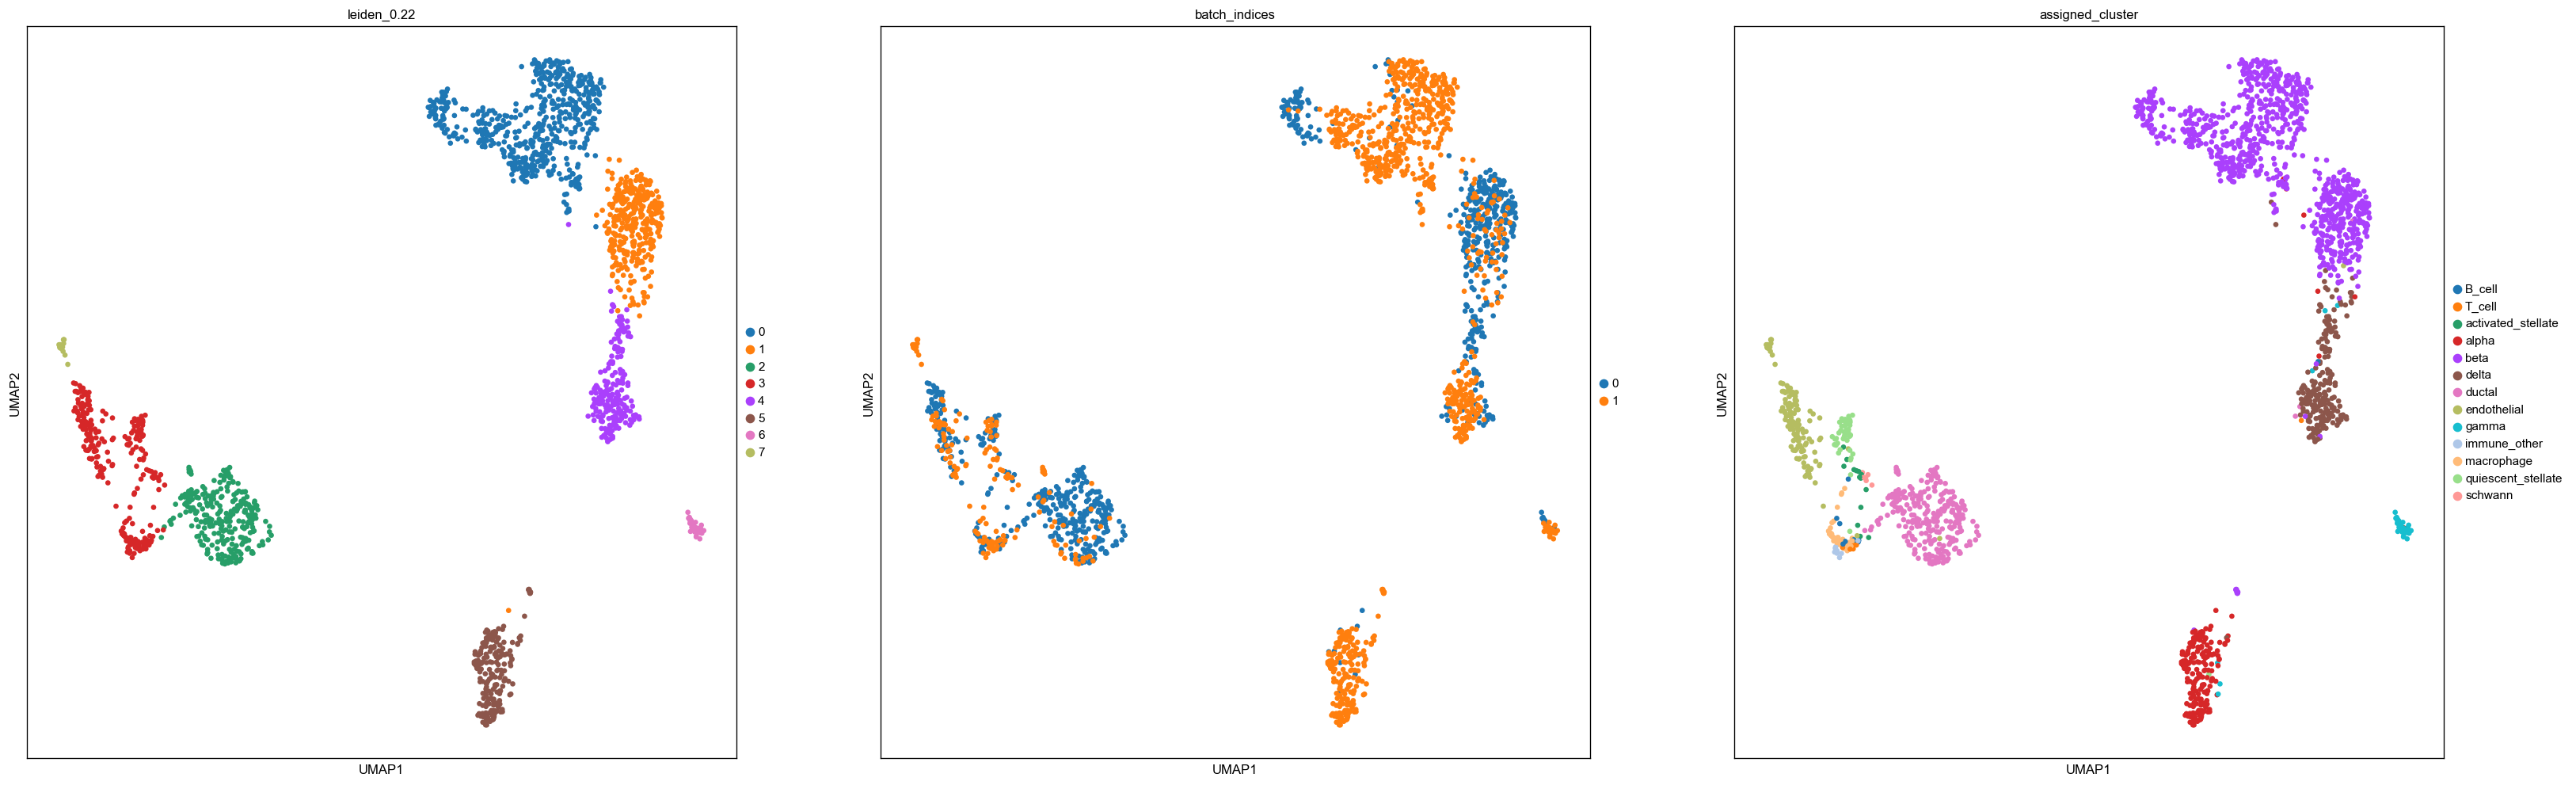

In [8]:
result = evaluate(mp, resolutions = [0.1, 0.13, 0.19, 0.22, 0.25, 0.28], return_fig=True, cell_type_col="assigned_cluster", batch_col="batch_indices")

### Transfer learning with scETM

Transfer learning with scETM is extremely simple. Just train scETM on the reference dataset and apply it to the query dataset, and bingo, transfer complete! Note that for zero-shot transfer (i.e. no fine-tuning), the gene sets of the reference and query sets must be aligned. We will demonstrate the aligning procedure in the code below.

If you wish to further fine-tune the model on the query dataset, then you would need to call the `prepare_for_transfer` function and instantiate a new trainer to train the model.

In [5]:
common_genes = mp.var_names.str.upper().intersection(hp.var_names)
common_genes

Index(['A1CF', 'A4GALT', 'AAAS', 'AACS', 'AADAC', 'AAED1', 'AAGAB', 'AAK1',
       'AAMDC', 'AAMP',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=12473)

In [6]:
mp_gene_mask = [gene for gene in mp.var_names if gene.upper() in common_genes]
mp_aligned = mp[:, mp_gene_mask].copy()
hp_gene_mask = pd.Series(mp_gene_mask).str.upper()
hp_aligned = hp[:, hp_gene_mask].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
mp_aligned

AnnData object with n_obs × n_vars = 1886 × 12474
    obs: 'barcode', 'assigned_cluster', 'batch_indices'

In [9]:
hp_aligned

AnnData object with n_obs × n_vars = 8569 × 12474
    obs: 'barcode', 'assigned_cluster', 'batch_indices'

In [9]:
mp_aligned.var_names

Index(['A1cf', 'A4galt', 'Aaas', 'Aacs', 'Aadac', 'Aaed1', 'Aagab', 'Aak1',
       'Aamdc', 'Aamp',
       ...
       'Zufsp', 'Zw10', 'Zwilch', 'Zwint', 'Zxdb', 'Zxdc', 'Zyg11b', 'Zyx',
       'Zzef1', 'Zzz3'],
      dtype='object', length=12474)

In [10]:
hp_aligned.var_names

Index(['A1CF', 'A4GALT', 'AAAS', 'AACS', 'AADAC', 'AAED1', 'AAGAB', 'AAK1',
       'AAMDC', 'AAMP',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=12474)

In [7]:
mp_aligned_model = scETM(mp_aligned.n_vars, mp_aligned.obs.batch_indices.nunique())
trainer = UnsupervisedTrainer(mp_aligned_model, mp_aligned)
trainer.train(n_epochs = 12000, eval_every = 3000, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

[2021-05-10 15:13:38,960] INFO - scETM.logging_utils: scETM.__init__(12474, 2)
[2021-05-10 15:13:40,615] INFO - scETM.logging_utils: UnsupervisedTrainer.__init__(scETM(
  (q_delta): Sequential(
    (0): Linear(in_features=12474, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (mu_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (logsigma_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (rho_trainable_emb): PartlyTrainableParameter2D(height=400, fixed=0, trainable=12474)
), AnnData object with n_obs × n_vars = 1886 × 12474
    obs: 'barcode', 'assigned_cluster', 'batch_indices')
[2021-05-10 15:13:40,616] INFO - scETM.logging_utils: UnsupervisedTrainer.train(<scETM.trainer.UnsupervisedTrainer object at 0x000001D4AAFD52C8>, n_epochs = 12000, eval_every = 3000, eval_kwargs = {'cell_type_col': 'assigned_cluster'}, save_model_ckpt =

[2021-05-10 15:24:24,585] INFO - scETM.logging_utils: scETM.__init__(12474, 2)
[2021-05-10 15:24:24,667] WARNING - scETM.model.BaseCellModel: adata.obs[batch_indices] contains 4 batches, while self.n_batches == 2.
[2021-05-10 15:24:24,668] WARNING - scETM.model.BaseCellModel: Disable decoding. You will not get reconstructed cell-gene matrix or nll.
[2021-05-10 15:24:25,048] INFO - scETM.logging_utils: evaluate(AnnData object with n_obs × n_vars = 8569 × 12474
    obs: 'barcode', 'assigned_cluster', 'batch_indices'
    obsm: 'delta', resolutions = [0.08, 0.12, 0.17, 0.23, 0.3, 0.4], return_fig = True, cell_type_col = assigned_cluster, batch_col = batch_indices)
[2021-05-10 15:24:25,049] WARNING - scETM.eval_utils: scETM.evaluate assumes discrete cell types. Converting cell_type_col to categorical.
[2021-05-10 15:24:36,668] INFO - scETM.eval_utils: Performing leiden clustering
[2021-05-10 15:24:38,409] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.5687	NMI:  0.7056	bARI:  0.0135	# l

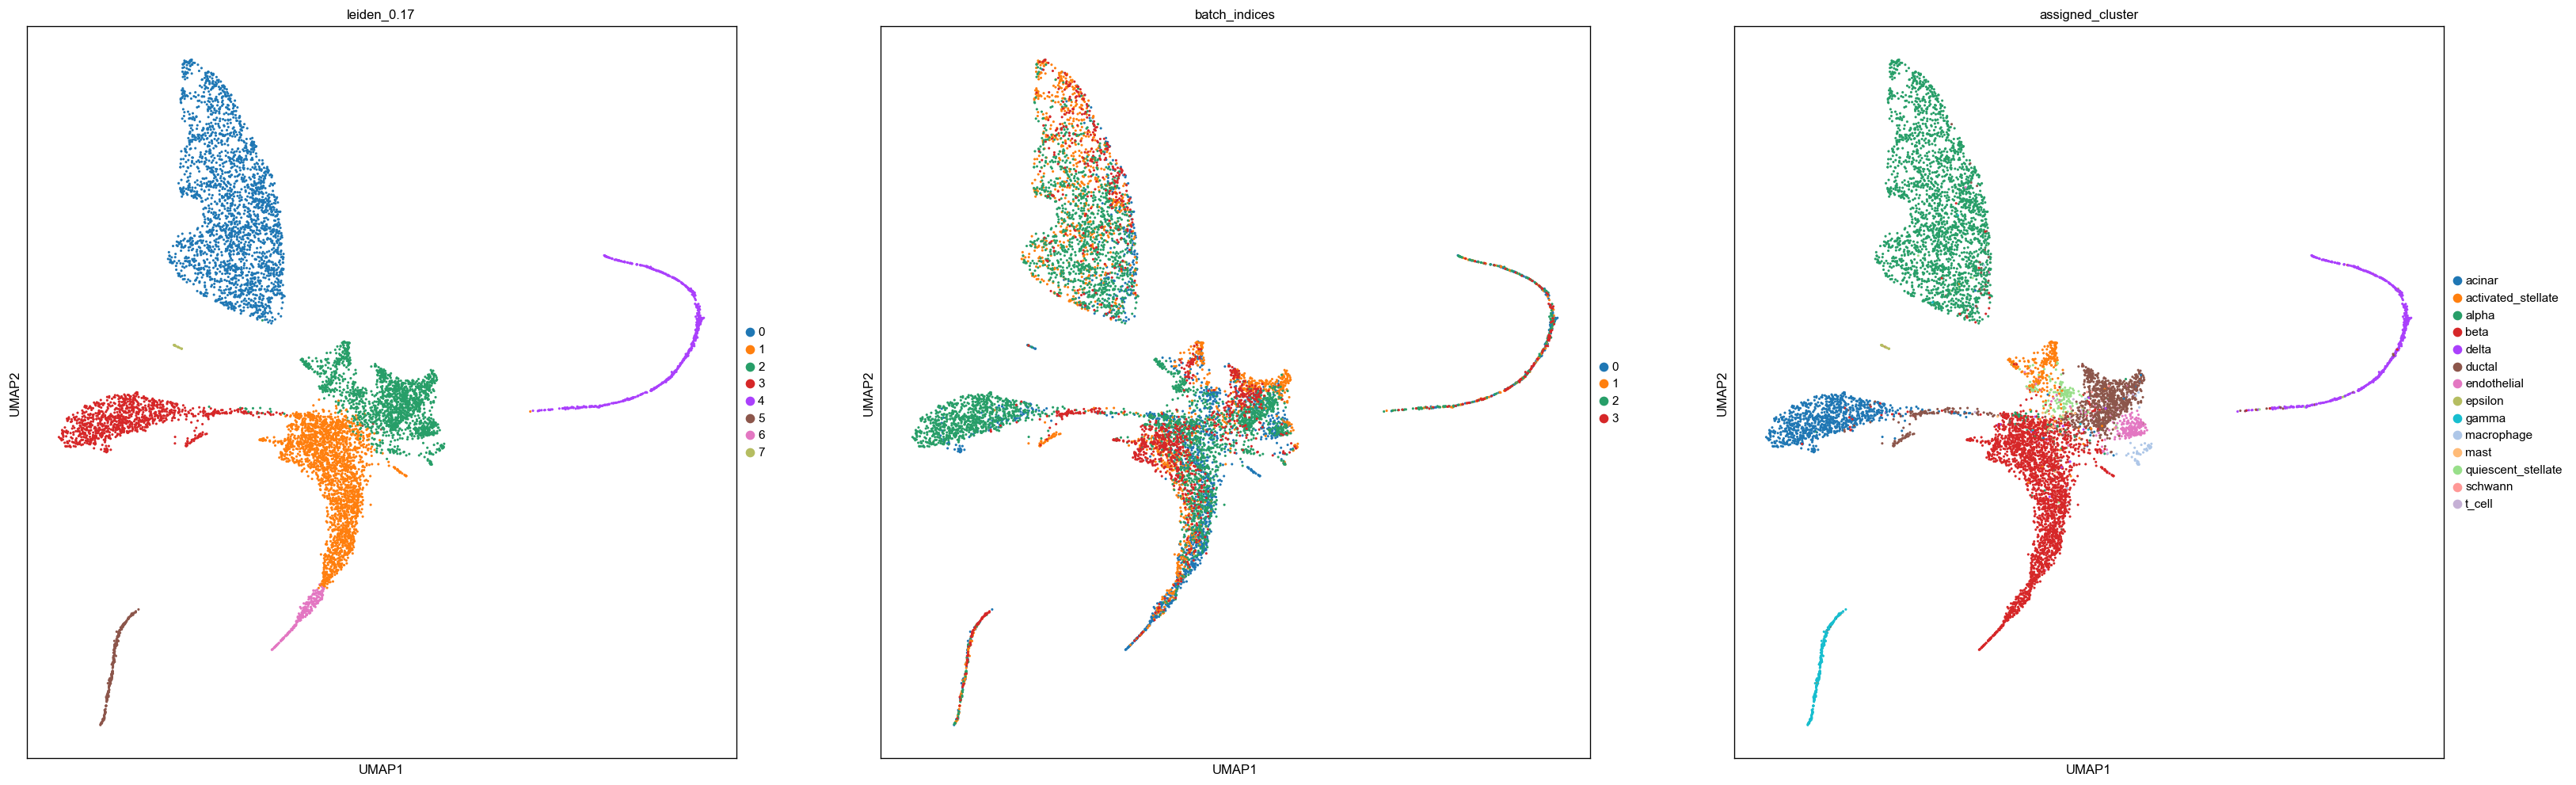

In [8]:
mp_aligned_model = scETM(mp_aligned.n_vars, mp_aligned.obs.batch_indices.nunique())
mp_aligned_model.get_cell_embeddings_and_nll(hp_aligned, emb_names=['delta'])
result = evaluate(hp_aligned, resolutions = [0.08, 0.12, 0.17, 0.23, 0.3, 0.4], return_fig=True, cell_type_col="assigned_cluster", batch_col="batch_indices")

In [10]:
hp_aligned.var_names_make_unique()
hp_aligned_model, hp_aligned = prepare_for_transfer(mp_aligned_model, hp_aligned, hp_aligned.var_names, fix_shared_genes=False)

[2021-05-10 15:31:25,167] INFO - scETM.logging_utils: prepare_for_transfer(scETM(
  (q_delta): Sequential(
    (0): Linear(in_features=12474, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (mu_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (logsigma_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (rho_trainable_emb): PartlyTrainableParameter2D(height=400, fixed=0, trainable=12474)
), AnnData object with n_obs × n_vars = 8569 × 12474
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'leiden_0.08', 'leiden_0.12', 'leiden_0.17', 'leiden_0.23', 'leiden_0.3', 'leiden_0.4'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_0.17_colors', 'batch_indices_colors', 'assigned_cluster_colors'
    obsm: 'delta', 'knn_indices', 'X_umap'
    obsp: 'distances', 'connectivities', Index(['A1CF', 'A4GALT', 'AAAS', 'AACS', 'AADAC', 'AAED1'

In [ ]:
trainer = UnsupervisedTrainer(hp_aligned_model, hp_aligned, init_lr = 5e-4)
trainer.train(n_epochs = 300, eval_every = 100, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

### Training p-scETM

Pathway-informed scETM (p-scETM) uses a pathway-gene matrix from external database as part/all of scETM gene embedding rho. In this tutorial, we will use the pathDIP data.

The pathDIP data can be downloaded from http://ophid.utoronto.ca/pathDIP/Download.jsp.

In [3]:
pathdip4 = pd.read_csv('../../../data/pathway_gene_matv4.csv', index_col=0)

In [4]:
# filter pathways with less than 5 genes in it
pathdip4 = pathdip4.loc[:, pathdip4.sum(0) >= 5].T

In [5]:
pathdip4

,IGKV2-28,IGKV1-27,IGKV2D-30,IGKV2-40,CYP2D7,UQCRHL,IGKV3D-11,TRAV19,GATD3B,SIK1B,...,MAU2,ENPP4,MYO16,MORC2,IVNS1ABP,SEC23IP,LY96,COLEC10,A3GALT2,PYDC5
Adaptive Immune System,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Antigen activates B Cell Receptor (BCR) leading to generation of second messengers,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Binding and Uptake of Ligands by Scavenger Receptors,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD22 mediated BCR regulation,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cell surface interactions at the vascular wall,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Competing endogenous RNAs (ceRNAs) regulate PTEN translation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Post-transcriptional silencing by small RNAs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Coenzyme_A_biosynthesis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Interleukin-36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# extend the pathway-gene matrix to all genes in the human pancreas dataset, filling missing values with 0.0
pathdip4_hp = pathdip4.reindex(columns = hp.var_names, fill_value=0.0)

# instantiate a p-scETM model, passingt he pathway-gene matrix to rho_fixed_emb
hp_model = scETM(hp.n_vars, hp.obs.batch_indices.nunique(), rho_fixed_emb=pathdip4_hp.values)

# instantiate the trainer
trainer = UnsupervisedTrainer(hp_model, hp, test_ratio=0.1)

# trainer the p-scETM
trainer.train(n_epochs = 900, eval_every = 300, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

[2021-05-10 11:19:40,592] INFO - scETM.logging_utils: scETM.__init__(20125, 4, rho_fixed_emb = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]])
[2021-05-10 11:19:42,408] INFO - scETM.logging_utils: UnsupervisedTrainer.__init__(scETM(
  (q_delta): Sequential(
    (0): Linear(in_features=20125, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (mu_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (logsigma_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (rho_trainable_emb): PartlyTrainableParameter2D(height=400, fixed=0, trainable=20125)
), AnnData object with n_obs × n_vars = 8569 × 20125
    obs: 'barcode', 'assigned_cluster', 'batch_indices', test_ratio = 0.1)
[2021-05-10 11:19:42,414] INFO - scETM.trainer: Keeping 856 ce